# Vector Databases with FAISS

This notebook demonstrates how to use FAISS (Facebook AI Similarity Search) for efficient similarity search at scale.

## Overview

FAISS enables efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM.

## Learning Objectives

- Understand different FAISS index types
- Compare performance characteristics
- Implement scalable vector search
- Benchmark search quality vs. speed trade-offs

## Setup and Imports

In [1]:
# Set environment variable to avoid tokenizers warning
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Import necessary libraries
import numpy as np
import time
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"FAISS version: {faiss.__version__}")

Libraries imported successfully!
FAISS version: 1.11.0


## Load Embedding Model

In [2]:
# Load the sentence transformer model
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded successfully!")

# Test the model
test_embedding = model.encode("Hello, FAISS!")
print(f"\nEmbedding dimension: {len(test_embedding)}")

Loading sentence transformer model...
Model loaded successfully!

Embedding dimension: 384


## Generate Synthetic Dataset

Let's create a larger dataset to demonstrate FAISS capabilities:

In [3]:
# Generate a larger dataset for FAISS demonstration
np.random.seed(42)

# Create synthetic documents
num_documents = 1000
categories = ['tech', 'health', 'finance', 'education', 'travel']
synthetic_docs = []

templates = {
    'tech': ['software', 'hardware', 'programming', 'AI', 'data'],
    'health': ['wellness', 'medicine', 'fitness', 'nutrition', 'mental'],
    'finance': ['investment', 'banking', 'budget', 'savings', 'credit'],
    'education': ['learning', 'teaching', 'courses', 'degree', 'skills'],
    'travel': ['vacation', 'destination', 'flights', 'hotels', 'adventure']
}

for i in range(num_documents):
    cat = np.random.choice(categories)
    word = np.random.choice(templates[cat])
    synthetic_docs.append(f"Document about {word} in {cat} category #{i}")

print(f"Generated {len(synthetic_docs)} synthetic documents")
print("\nSample documents:")
for i in range(5):
    print(f"  - {synthetic_docs[i]}")

Generated 1000 synthetic documents

Sample documents:
  - Document about skills in education category #0
  - Document about credit in finance category #1
  - Document about destination in travel category #2
  - Document about budget in finance category #3
  - Document about credit in finance category #4


In [4]:
# Compare different FAISS index types
import time

# Check if we have the necessary variables
if 'doc_embeddings' not in globals() or 'synthetic_docs' not in globals():
    print("⚠️ Required data not found. Let's create it now...")
    
    # Generate synthetic documents if not already created
    if 'synthetic_docs' not in globals():
        np.random.seed(42)
        num_documents = 1000
        categories = ['tech', 'health', 'finance', 'education', 'travel']
        synthetic_docs = []
        
        templates = {
            'tech': ['software', 'hardware', 'programming', 'AI', 'data'],
            'health': ['wellness', 'medicine', 'fitness', 'nutrition', 'mental'],
            'finance': ['investment', 'banking', 'budget', 'savings', 'credit'],
            'education': ['learning', 'teaching', 'courses', 'degree', 'skills'],
            'travel': ['vacation', 'destination', 'flights', 'hotels', 'adventure']
        }
        
        for i in range(num_documents):
            cat = np.random.choice(categories)
            word = np.random.choice(templates[cat])
            synthetic_docs.append(f"Document about {word} in {cat} category #{i}")
    
    # Generate embeddings if not already created
    if 'doc_embeddings' not in globals():
        print("Generating embeddings...")
        if 'model' not in globals():
            model = SentenceTransformer('all-MiniLM-L6-v2')
        doc_embeddings = model.encode(synthetic_docs, batch_size=32, show_progress_bar=True)
        doc_embeddings = doc_embeddings.astype('float32')
        print(f"Generated embeddings with shape: {doc_embeddings.shape}")

# Now proceed with the index comparison
dimension = doc_embeddings.shape[1]
indices = {}
build_times = {}

# 1. Exact search (IndexFlatL2)
start = time.time()
index_flat = faiss.IndexFlatL2(dimension)
index_flat.add(doc_embeddings)
build_times['Flat L2 (Exact)'] = time.time() - start
indices['Flat L2 (Exact)'] = index_flat

# 2. Approximate search (IndexIVFFlat)
start = time.time()
nlist = 50  # Number of clusters
quantizer = faiss.IndexFlatL2(dimension)
index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist)
index_ivf.train(doc_embeddings)  # Training required
index_ivf.add(doc_embeddings)
build_times['IVF Flat (Approximate)'] = time.time() - start
indices['IVF Flat (Approximate)'] = index_ivf

# 3. Graph-based search (IndexHNSWFlat)
start = time.time()
index_hnsw = faiss.IndexHNSWFlat(dimension, 32)  # 32 is the connectivity parameter
index_hnsw.add(doc_embeddings)
build_times['HNSW (Graph)'] = time.time() - start
indices['HNSW (Graph)'] = index_hnsw

print("Index Build Times:")
for name, time_taken in build_times.items():
    print(f"  {name}: {time_taken:.3f} seconds")

⚠️ Required data not found. Let's create it now...
Generating embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Generated embeddings with shape: (1000, 384)
Index Build Times:
  Flat L2 (Exact): 0.001 seconds
  IVF Flat (Approximate): 0.008 seconds
  HNSW (Graph): 0.006 seconds


WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points


In [6]:
# Generate embeddings for all documents
print("Generating embeddings...")
doc_embeddings = model.encode(synthetic_docs, batch_size=32, show_progress_bar=True)
doc_embeddings = doc_embeddings.astype('float32')  # FAISS requires float32

print(f"\nEmbeddings shape: {doc_embeddings.shape}")
print(f"Memory usage: {doc_embeddings.nbytes / 1024 / 1024:.2f} MB")

Generating embeddings...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]


Embeddings shape: (1000, 384)
Memory usage: 1.46 MB


## Generate Embeddings

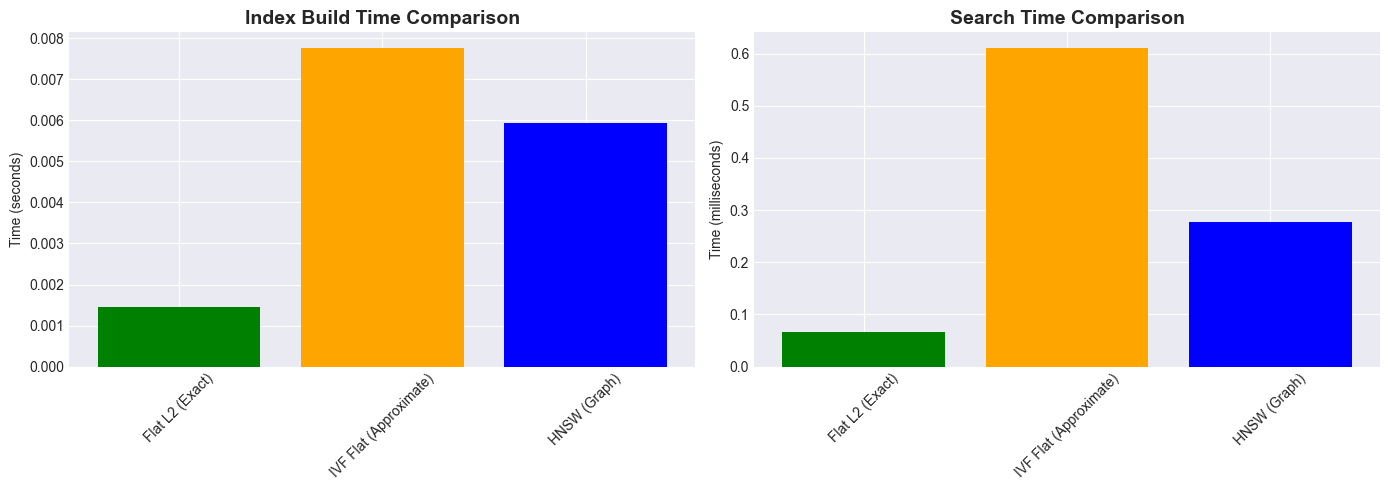


Query: 'Looking for AI and machine learning resources'

Top 5 results from each index type:

Flat L2 (Exact):
  1. Document about AI in tech category #807... (distance: 0.784)
  2. Document about AI in tech category #869... (distance: 0.791)
  3. Document about AI in tech category #437... (distance: 0.794)
  4. Document about AI in tech category #884... (distance: 0.794)
  5. Document about AI in tech category #256... (distance: 0.799)

IVF Flat (Approximate):
  1. Document about AI in tech category #807... (distance: 0.784)
  2. Document about AI in tech category #869... (distance: 0.791)
  3. Document about AI in tech category #437... (distance: 0.794)
  4. Document about AI in tech category #884... (distance: 0.794)
  5. Document about AI in tech category #256... (distance: 0.799)

HNSW (Graph):
  1. Document about AI in tech category #807... (distance: 0.784)
  2. Document about AI in tech category #869... (distance: 0.791)
  3. Document about AI in tech category #437... (distance

In [7]:
# Benchmark search performance
if 'indices' not in globals() or not indices:
    print("⚠️ Indices not found. Please run the previous cell first to build indices!")
elif 'model' not in globals():
    print("⚠️ Model not found. Loading model...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
else:
    query = "Looking for AI and machine learning resources"
    query_embedding = model.encode([query]).astype('float32')
    k = 10  # Number of neighbors

    search_times = {}
    search_results = {}

    for name, index in indices.items():
        # Set search parameters for IVF
        if 'IVF' in name:
            index.nprobe = 10  # Number of clusters to search
        
        # Perform search
        start = time.time()
        distances, indices_found = index.search(query_embedding, k)
        search_times[name] = (time.time() - start) * 1000  # Convert to ms
        search_results[name] = (distances[0], indices_found[0])

    # Visualize performance comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Build times
    names = list(build_times.keys())
    build_values = list(build_times.values())
    ax1.bar(names, build_values, color=['green', 'orange', 'blue'])
    ax1.set_title('Index Build Time Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Time (seconds)')
    ax1.tick_params(axis='x', rotation=45)

    # Search times
    search_values = list(search_times.values())
    ax2.bar(names, search_values, color=['green', 'orange', 'blue'])
    ax2.set_title('Search Time Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Time (milliseconds)')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Display search results
    print(f"\nQuery: '{query}'")
    print("\nTop 5 results from each index type:")
    for name, (distances, indices_found) in search_results.items():
        print(f"\n{name}:")
        for i in range(5):
            idx = indices_found[i]
            dist = distances[i]
            print(f"  {i+1}. {synthetic_docs[idx][:60]}... (distance: {dist:.3f})")

## Compare Different FAISS Index Types

FAISS provides several index types with different trade-offs between search quality and speed:

In [8]:
# Compare different FAISS index types
dimension = doc_embeddings.shape[1]
indices = {}
build_times = {}

# 1. Exact search (IndexFlatL2)
start = time.time()
index_flat = faiss.IndexFlatL2(dimension)
index_flat.add(doc_embeddings)
build_times['Flat L2 (Exact)'] = time.time() - start
indices['Flat L2 (Exact)'] = index_flat

# 2. Approximate search (IndexIVFFlat)
start = time.time()
nlist = 50  # Number of clusters
quantizer = faiss.IndexFlatL2(dimension)
index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist)
index_ivf.train(doc_embeddings)  # Training required
index_ivf.add(doc_embeddings)
build_times['IVF Flat (Approximate)'] = time.time() - start
indices['IVF Flat (Approximate)'] = index_ivf

# 3. Graph-based search (IndexHNSWFlat)
start = time.time()
index_hnsw = faiss.IndexHNSWFlat(dimension, 32)  # 32 is the connectivity parameter
index_hnsw.add(doc_embeddings)
build_times['HNSW (Graph)'] = time.time() - start
indices['HNSW (Graph)'] = index_hnsw

print("Index Build Times:")
for name, time_taken in build_times.items():
    print(f"  {name}: {time_taken:.3f} seconds")

Index Build Times:
  Flat L2 (Exact): 0.001 seconds
  IVF Flat (Approximate): 0.006 seconds
  HNSW (Graph): 0.006 seconds


WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points


## Benchmark Search Performance

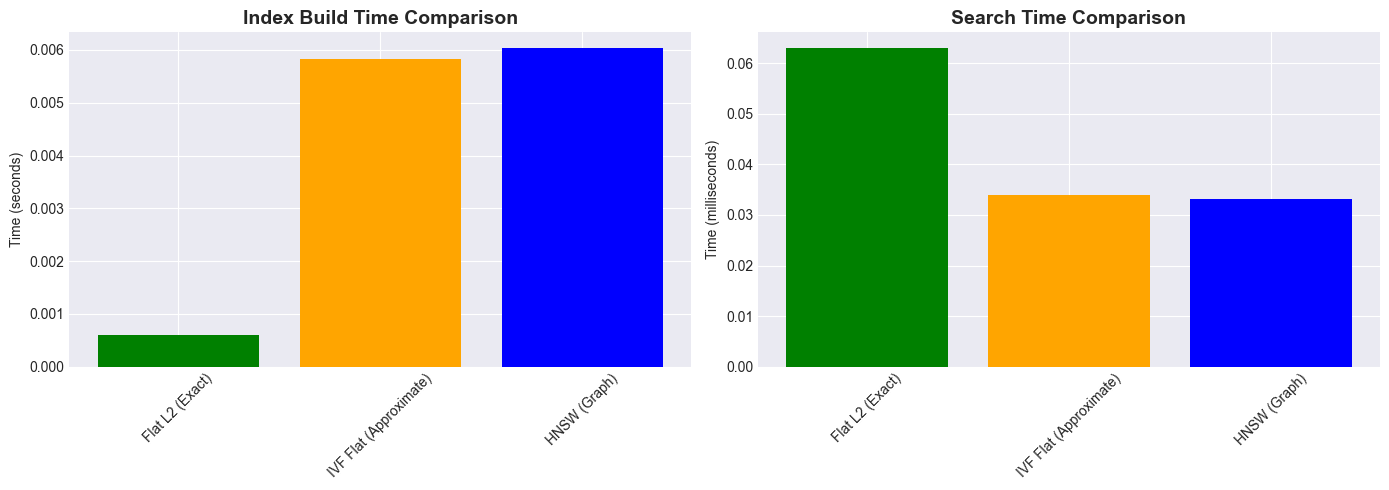


Query: 'Looking for AI and machine learning resources'

Top 5 results from each index type:

Flat L2 (Exact):
  1. Document about AI in tech category #807... (distance: 0.784)
  2. Document about AI in tech category #869... (distance: 0.791)
  3. Document about AI in tech category #437... (distance: 0.794)
  4. Document about AI in tech category #884... (distance: 0.794)
  5. Document about AI in tech category #256... (distance: 0.799)

IVF Flat (Approximate):
  1. Document about AI in tech category #807... (distance: 0.784)
  2. Document about AI in tech category #869... (distance: 0.791)
  3. Document about AI in tech category #437... (distance: 0.794)
  4. Document about AI in tech category #884... (distance: 0.794)
  5. Document about AI in tech category #256... (distance: 0.799)

HNSW (Graph):
  1. Document about AI in tech category #807... (distance: 0.784)
  2. Document about AI in tech category #869... (distance: 0.791)
  3. Document about AI in tech category #437... (distance

In [9]:
# Benchmark search performance
query = "Looking for AI and machine learning resources"
query_embedding = model.encode([query]).astype('float32')
k = 10  # Number of neighbors

search_times = {}
search_results = {}

for name, index in indices.items():
    # Set search parameters for IVF
    if 'IVF' in name:
        index.nprobe = 10  # Number of clusters to search
    
    # Perform search
    start = time.time()
    distances, indices_found = index.search(query_embedding, k)
    search_times[name] = (time.time() - start) * 1000  # Convert to ms
    search_results[name] = (distances[0], indices_found[0])

# Visualize performance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Build times
names = list(build_times.keys())
build_values = list(build_times.values())
ax1.bar(names, build_values, color=['green', 'orange', 'blue'])
ax1.set_title('Index Build Time Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Time (seconds)')
ax1.tick_params(axis='x', rotation=45)

# Search times
search_values = list(search_times.values())
ax2.bar(names, search_values, color=['green', 'orange', 'blue'])
ax2.set_title('Search Time Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Time (milliseconds)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display search results
print(f"\nQuery: '{query}'")
print("\nTop 5 results from each index type:")
for name, (distances, indices_found) in search_results.items():
    print(f"\n{name}:")
    for i in range(5):
        idx = indices_found[i]
        dist = distances[i]
        print(f"  {i+1}. {synthetic_docs[idx][:60]}... (distance: {dist:.3f})")

## Advanced FAISS Features

### 1. Index with Product Quantization (Memory Efficient)

In [10]:
# Create a memory-efficient index using Product Quantization
# This reduces memory usage at the cost of some accuracy

# Parameters
nlist = 50  # Number of clusters
m = 8       # Number of subquantizers
nbits = 8   # Bits per subquantizer

# Create index
quantizer = faiss.IndexFlatL2(dimension)
index_pq = faiss.IndexIVFPQ(quantizer, dimension, nlist, m, nbits)

# Train the index
print("Training PQ index...")
index_pq.train(doc_embeddings)
index_pq.add(doc_embeddings)

# Compare memory usage
flat_memory = index_flat.ntotal * dimension * 4 / (1024 * 1024)  # MB
pq_memory = index_pq.ntotal * m * nbits / 8 / (1024 * 1024)  # MB

print(f"\nMemory Usage Comparison:")
print(f"  Flat Index: {flat_memory:.2f} MB")
print(f"  PQ Index: {pq_memory:.2f} MB")
print(f"  Compression Ratio: {flat_memory / pq_memory:.1f}x")

Training PQ index...
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.

Memory Usage Comparison:
  Flat Index: 1.46 MB
  PQ Index: 0.01 MB
  Compression Ratio: 192.0x


WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points


### 2. GPU Acceleration (if available)

In [11]:
# Check if GPU is available for FAISS
gpu_available = faiss.get_num_gpus() > 0
print(f"GPU available for FAISS: {gpu_available}")

if gpu_available:
    # Create GPU index
    res = faiss.StandardGpuResources()
    index_gpu = faiss.index_cpu_to_gpu(res, 0, index_flat)
    
    # Benchmark GPU vs CPU
    queries = model.encode(["test query " + str(i) for i in range(100)]).astype('float32')
    
    # CPU search
    start = time.time()
    index_flat.search(queries, k)
    cpu_time = time.time() - start
    
    # GPU search
    start = time.time()
    index_gpu.search(queries, k)
    gpu_time = time.time() - start
    
    print(f"\nBatch Search Performance (100 queries):")
    print(f"  CPU: {cpu_time:.3f} seconds")
    print(f"  GPU: {gpu_time:.3f} seconds")
    print(f"  Speedup: {cpu_time / gpu_time:.2f}x")
else:
    print("GPU not available - skipping GPU benchmarks")

GPU available for FAISS: False
GPU not available - skipping GPU benchmarks


### 3. Index Persistence

In [12]:
# Save and load FAISS indices
import tempfile

# Create a temporary directory for saving indices
with tempfile.TemporaryDirectory() as tmpdir:
    # Save index
    index_path = os.path.join(tmpdir, "faiss_index.bin")
    faiss.write_index(index_flat, index_path)
    print(f"Index saved to: {index_path}")
    print(f"File size: {os.path.getsize(index_path) / 1024 / 1024:.2f} MB")
    
    # Load index
    loaded_index = faiss.read_index(index_path)
    print(f"\nIndex loaded successfully")
    print(f"Number of vectors: {loaded_index.ntotal}")
    
    # Verify loaded index works
    test_query = model.encode(["test query"]).astype('float32')
    D, I = loaded_index.search(test_query, 5)
    print(f"\nTest search on loaded index successful")
    print(f"Top result: {synthetic_docs[I[0][0]][:50]}...")

Index saved to: /var/folders/tm/chrvt43s3rbdld20ghw1qtc40000gn/T/tmp69x91c77/faiss_index.bin
File size: 1.46 MB

Index loaded successfully
Number of vectors: 1000

Test search on loaded index successful
Top result: Document about data in tech category #52...


## Practical Tips for Using FAISS

### Choosing the Right Index Type

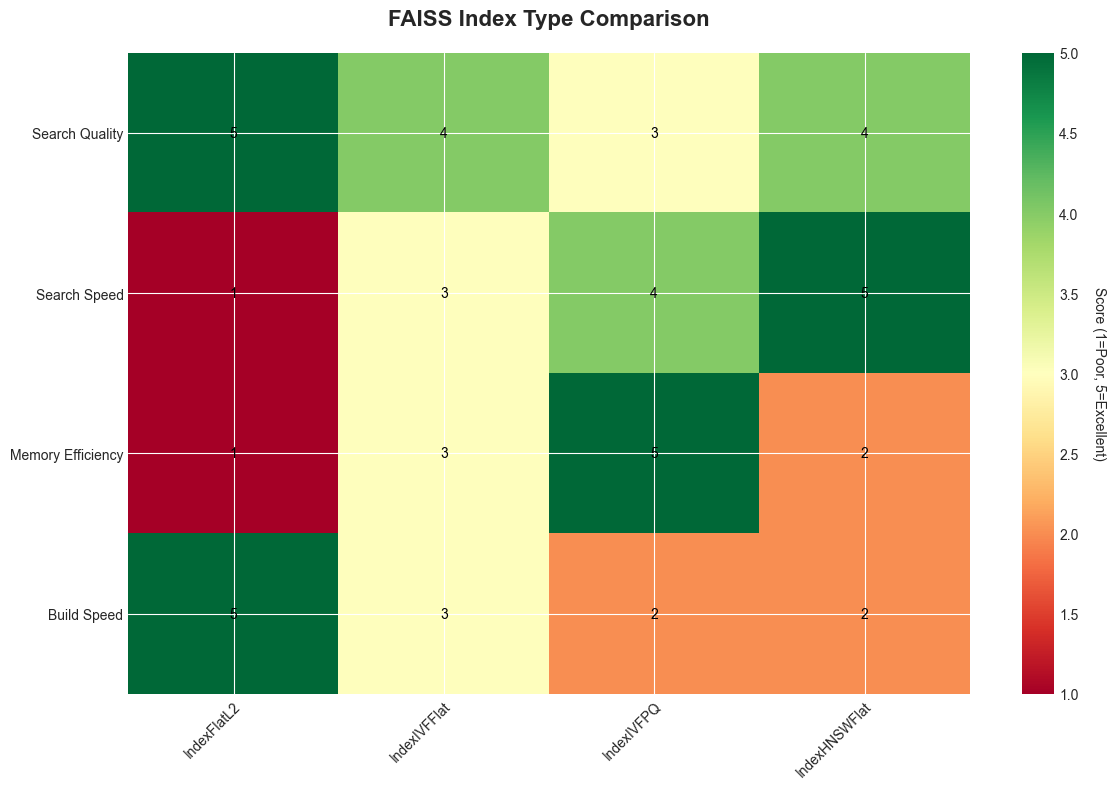


📊 Index Selection Guide:
• Small dataset (<10K vectors): Use IndexFlatL2 for exact search
• Medium dataset (10K-1M): Use IndexIVFFlat for good balance
• Large dataset with memory constraints: Use IndexIVFPQ
• Need very fast search: Use IndexHNSWFlat (but uses more memory)


In [13]:
# Create a decision guide visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Define index characteristics
index_types = ['IndexFlatL2', 'IndexIVFFlat', 'IndexIVFPQ', 'IndexHNSWFlat']
characteristics = ['Search Quality', 'Search Speed', 'Memory Efficiency', 'Build Speed']

# Scores (1-5 scale)
scores = np.array([
    [5, 1, 1, 5],  # IndexFlatL2
    [4, 3, 3, 3],  # IndexIVFFlat
    [3, 4, 5, 2],  # IndexIVFPQ
    [4, 5, 2, 2],  # IndexHNSWFlat
])

# Create heatmap
im = ax.imshow(scores.T, cmap='RdYlGn', aspect='auto', vmin=1, vmax=5)

# Set ticks and labels
ax.set_xticks(np.arange(len(index_types)))
ax.set_yticks(np.arange(len(characteristics)))
ax.set_xticklabels(index_types)
ax.set_yticklabels(characteristics)

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Score (1=Poor, 5=Excellent)', rotation=270, labelpad=20)

# Add text annotations
for i in range(len(index_types)):
    for j in range(len(characteristics)):
        text = ax.text(i, j, scores[i, j], ha="center", va="center", color="black")

ax.set_title('FAISS Index Type Comparison', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n📊 Index Selection Guide:")
print("• Small dataset (<10K vectors): Use IndexFlatL2 for exact search")
print("• Medium dataset (10K-1M): Use IndexIVFFlat for good balance")
print("• Large dataset with memory constraints: Use IndexIVFPQ")
print("• Need very fast search: Use IndexHNSWFlat (but uses more memory)")

## Real-World Example: Document Search System

In [14]:
# Create a more realistic document search system
class FAISSDocumentSearch:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)
        self.index = None
        self.documents = []
        
    def index_documents(self, documents, index_type='IVFFlat', nlist=None):
        """Index documents using specified FAISS index type"""
        self.documents = documents
        
        # Generate embeddings
        print(f"Generating embeddings for {len(documents)} documents...")
        embeddings = self.model.encode(documents, show_progress_bar=True)
        embeddings = embeddings.astype('float32')
        
        dimension = embeddings.shape[1]
        n_documents = len(documents)
        
        # Auto-adjust nlist if not provided
        if nlist is None:
            # Rule of thumb: sqrt(n) clusters, but at least 1 and no more than n_documents
            nlist = max(1, min(int(np.sqrt(n_documents)), n_documents))
            if index_type == 'IVFFlat':
                print(f"Auto-adjusted nlist to {nlist} based on {n_documents} documents")
        
        # Create index based on type
        if index_type == 'Flat':
            self.index = faiss.IndexFlatL2(dimension)
            self.index.add(embeddings)
        elif index_type == 'IVFFlat':
            # For small datasets, fall back to Flat index
            if n_documents < 40:
                print(f"⚠️ Only {n_documents} documents. Using Flat index instead of IVF for better results.")
                self.index = faiss.IndexFlatL2(dimension)
                self.index.add(embeddings)
            else:
                quantizer = faiss.IndexFlatL2(dimension)
                self.index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
                self.index.train(embeddings)
                self.index.add(embeddings)
        elif index_type == 'HNSW':
            self.index = faiss.IndexHNSWFlat(dimension, 32)
            self.index.add(embeddings)
        
        print(f"Indexed {self.index.ntotal} documents")
        
    def search(self, query, k=5):
        """Search for similar documents"""
        # Generate query embedding
        query_embedding = self.model.encode([query]).astype('float32')
        
        # Adjust k if we have fewer documents
        k = min(k, len(self.documents))
        
        # Search
        if hasattr(self.index, 'nprobe'):
            self.index.nprobe = 10  # For IVF indices
            
        distances, indices = self.index.search(query_embedding, k)
        
        # Format results
        results = []
        for dist, idx in zip(distances[0], indices[0]):
            results.append({
                'document': self.documents[idx],
                'distance': float(dist),
                'similarity': 1 / (1 + float(dist))  # Convert distance to similarity
            })
        
        return results

# Create example documents
example_docs = [
    "Python is a versatile programming language used for web development.",
    "Machine learning algorithms can predict future trends from historical data.",
    "Natural language processing helps computers understand human language.",
    "Deep learning neural networks are inspired by the human brain.",
    "Data science combines statistics, programming, and domain knowledge.",
    "Cloud computing provides on-demand access to computing resources.",
    "Cybersecurity protects systems and networks from digital attacks.",
    "DevOps practices combine software development and IT operations.",
    "Blockchain technology enables secure, decentralized transactions.",
    "Artificial intelligence aims to create intelligent machines."
]

# Initialize and test the system
search_system = FAISSDocumentSearch()
search_system.index_documents(example_docs, index_type='IVFFlat')

# Test queries
test_queries = [
    "How does AI work?",
    "Security best practices",
    "Programming for beginners"
]

for query in test_queries:
    print(f"\n🔍 Query: '{query}'")
    results = search_system.search(query, k=3)
    for i, result in enumerate(results, 1):
        print(f"  {i}. {result['document'][:70]}...")
        print(f"     Similarity: {result['similarity']:.3f}")

Generating embeddings for 10 documents...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Auto-adjusted nlist to 3 based on 10 documents
⚠️ Only 10 documents. Using Flat index instead of IVF for better results.
Indexed 10 documents

🔍 Query: 'How does AI work?'
  1. Artificial intelligence aims to create intelligent machines....
     Similarity: 0.594
  2. Deep learning neural networks are inspired by the human brain....
     Similarity: 0.481
  3. Natural language processing helps computers understand human language....
     Similarity: 0.471

🔍 Query: 'Security best practices'
  1. Cybersecurity protects systems and networks from digital attacks....
     Similarity: 0.462
  2. Blockchain technology enables secure, decentralized transactions....
     Similarity: 0.398
  3. DevOps practices combine software development and IT operations....
     Similarity: 0.366

🔍 Query: 'Programming for beginners'
  1. Python is a versatile programming language used for web development....
     Similarity: 0.466
  2. Data science combines statistics, programming, and domain knowledge....

## Conclusion

FAISS is a powerful library for similarity search that enables:

1. **Scalable Search**: Handle millions or billions of vectors
2. **Flexible Trade-offs**: Choose between accuracy and speed
3. **Memory Efficiency**: Use quantization for large-scale deployments
4. **GPU Acceleration**: Leverage GPUs for faster search

### Key Takeaways:

- **IndexFlatL2**: Best for small datasets requiring exact search
- **IndexIVFFlat**: Good balance for medium-sized datasets
- **IndexIVFPQ**: Memory-efficient for large datasets
- **IndexHNSWFlat**: Fast search with graph-based approach

### Next Steps:

- Experiment with different index types for your use case
- Try GPU acceleration for larger datasets
- Explore advanced features like index sharding
- Combine FAISS with filtering for hybrid search

For more information, visit the [FAISS documentation](https://github.com/facebookresearch/faiss/wiki).